In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

import os
import imageio

import matplotlib.pyplot as plt

from dataset import get_rays
from rendering import rendering
from model import Voxels
from ml_helpers import training

The data is stored in fox/fox.

There are train and test images
There are instrisics of the form
fx
0
cx
0
0
fy
cy
0
0
0
1
0
0
0
0
1
Which is a 4x4 matrix like representation of intrinsics (more info here: https://ksimek.github.io/2013/08/13/intrinsic/)

The cx, cy are the center of the image.
fx and fy are focal length in x and y directions


# Camera/Dataset

In [11]:
batch_size=1000
o,d, target_px_values=get_rays("../fox/fox")

dataloader=DataLoader(torch.cat((torch.from_numpy(o),torch.from_numpy(d),torch.from_numpy(target_px_values)), dim=1), batch_size=batch_size, shuffle=True)
dataloader_warmup=DataLoader(torch.cat((torch.from_numpy(o).reshape(90,400, 400, 3)[:,100:300,100:300,:].reshape(-1,3),
                                        torch.from_numpy(d).reshape(90,400, 400, 3)[:,100:300,100:300,:].reshape(-1,3),
                                        torch.from_numpy(target_px_values.reshape(90,400, 400, 3)[:,100:300,100:300,:].reshape(-1,3))), 
                                        dim=1), batch_size=batch_size, shuffle=True)



test_o, test_d, test_target_px_values=get_rays("../fox/fox", "test")

In [3]:
test_o.shape

(10, 160000, 3)

[0. 0. 0. 0.]


/tmp/ipykernel_17735/1685041013.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("../fox/fox/imgs/" + img_file_names[0]) /255.


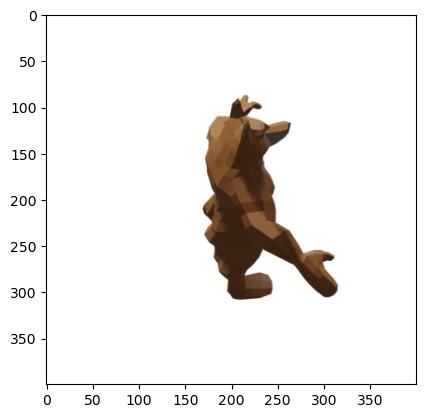

In [4]:
# extract an image from the dataset
img_file_names=[f for f in os.listdir("../fox/fox/imgs") if "train" in f]
img = imageio.imread("../fox/fox/imgs/" + img_file_names[0]) /255.

print(img[0,0,:])
#if img.shape[2]==4:
    #img=img[..., :3]*img[..., -1:] + (1.-img[..., -1:])
#    img=img[..., :3]*img[..., -1:]

# plot the image
plt.imshow(img)

# Rendering

Note: The original NeRF paper does two additional sampling technics that are not implemented here:
1. points are not linearly separated along the rays.

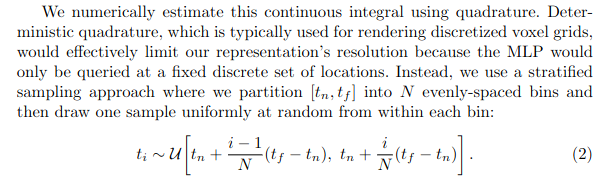

2. The loss is divided in two elements Cc and Cf with two different sampling technics. Cc is the "normal" one and Cf samples around the zones where Cc's points are very dense.

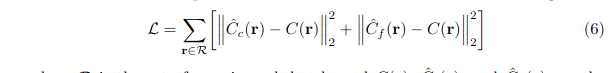

# Model

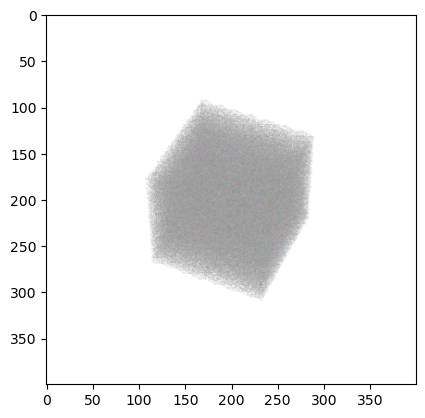

In [5]:
datapath="../fox/fox"
o,d,_=get_rays(datapath, mode="train")

H=400
W=400
tn=8 # we adapt it to the distance from the origin
tf = 12 # we adapt it to the distance from the origin
nb_bins=100
model = Voxels(nb_voxels=100, scale=1, device="cpu")
px_colors=rendering(model,torch.from_numpy(o[0]), torch.from_numpy(d[0]), tn, tf)

img=px_colors.reshape(H,W,3)
plt.figure(dpi=100)
plt.imshow(img.data.cpu().numpy())

Now we can choose which values of scale will be big enough to contain our representation of the fox. For that we use the real camera position and we compare different size of cube to the depicted fox. 3 is good.

# Training

In [13]:
device="cuda"
model= Voxels(scale=3, device=device)
nb_epochs=15
tn=8 # we adapt it to the distance from the origin
tf = 12 # we adapt it to the distance from the origin
nb_bins=100
batch_size=1000
o,d, target_px_values=get_rays("../fox/fox")
lr=1e-3
gamma=0.5

dataloader=DataLoader(torch.cat((torch.from_numpy(o).reshape(-1,3),
                                 torch.from_numpy(d).reshape(-1,3),
                                 torch.from_numpy(target_px_values).reshape(-1,3)), 
                                 dim=1), batch_size=batch_size, shuffle=True)

optimizer= torch.optim.Adam(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[5,10], gamma=gamma)

train_loss=training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device)
train_loss=training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device)

 10%|█         | 1449/14400 [00:10<01:22, 157.51it/s]

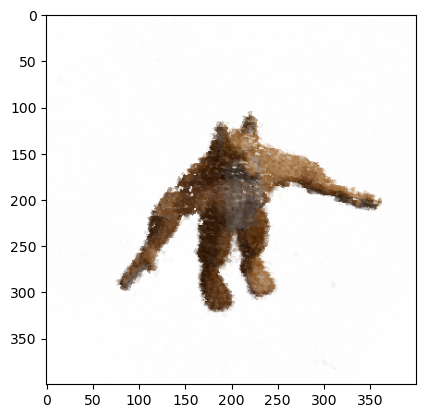

In [9]:
img= rendering(model,torch.from_numpy(o[0]).to(device), torch.from_numpy(d[0]).to(device), tn, tf, nb_bins=nb_bins, device=device)

img=img.reshape(H,W,3)
plt.figure(dpi=100)
plt.imshow(img.data.cpu().numpy())


In [12]:
#let's backup
torch.save(model.state_dict(), "model2.pth")
